# Exercise 4: Multi-Class Classification with Deeper MLP

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import itertools

In [60]:
def sample_class_from_make_classification_multiclass(
    target_label: int, 
    n_desired: int, 
    n_classes: int, 
    n_features: int, 
    n_informative: int, 
    n_clusters_per_class: int, 
    class_sep: float, 
    random_state: int
):
    rng = np.random.RandomState(random_state)
    X_list, y_list = [], []
    total_collected = 0
    batch = max(900, n_desired * 2)
    while total_collected < n_desired:
        Xb, yb = make_classification(
            n_samples=batch, 
            n_features=n_features, 
            n_informative=n_informative,
            n_redundant=0, 
            n_repeated=0, 
            n_classes=n_classes,
            n_clusters_per_class=n_clusters_per_class, 
            class_sep=class_sep,
            flip_y=0.0, 
            random_state=rng.randint(0,10_000_000)
        )
        mask = (yb == target_label)
        X_keep, y_keep = Xb[mask], yb[mask]
        need = n_desired - total_collected
        if len(X_keep) > need:
            X_keep, y_keep = X_keep[:need], y_keep[:need]
        X_list.append(X_keep)
        y_list.append(y_keep)
        total_collected += len(X_keep)
    return np.vstack(X_list), np.concatenate(y_list)

In [61]:
n_per_class = 500
n_classes = 3
n_features = 4
X0, y0 = sample_class_from_make_classification_multiclass(0, n_per_class, 3, 4, 4, 2, 1.6, 42)
X1, y1 = sample_class_from_make_classification_multiclass(1, n_per_class, 3, 4, 4, 3, 1.6, 1337)
X2, y2 = sample_class_from_make_classification_multiclass(2, n_per_class, 3, 4, 4, 4, 1.6, 2025)
y0[:] = 0
y1[:] = 1
y2[:] = 2
X = np.vstack([X0, X1, X2])
y = np.concatenate([y0, y1, y2])
rs = np.random.RandomState(222)
idx = rs.permutation(len(y))
X, y = X[idx], y[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [62]:
class ScratchDeepMLPSoftmax:
    def __init__(self, input_dim, hidden1, hidden2, output_dim, lr=0.05, seed=123, l2=1e-4):
        rng=np.random.RandomState(seed)
        def glorot(f_in,f_out):
            lim=np.sqrt(6/(f_in+f_out))
            return rng.uniform(-lim, lim, (f_in,f_out))
        self.W1=glorot(input_dim, hidden1)
        self.b1=np.zeros((1, hidden1))
        self.W2=glorot(hidden1, hidden2)
        self.b2=np.zeros((1, hidden2))
        self.W3=glorot(hidden2, output_dim)
        self.b3=np.zeros((1, output_dim))
        self.lr=lr
        self.l2=l2

    @staticmethod
    def tanh(x): return np.tanh(x)

    @staticmethod
    def tanh_deriv(a): return 1-a**2

    @staticmethod
    def softmax(z):
        z=z-np.max(z, axis=1, keepdims=True)
        ez=np.exp(z) 
        return ez/np.sum(ez, axis=1, keepdims=True)
    
    @staticmethod
    def one_hot(y, C):
        Y=np.zeros((y.shape[0], C))
        Y[np.arange(y.shape[0]), y]=1
        return Y
    
    def forward(self, X):
        z1=X@self.W1+self.b1
        a1=self.tanh(z1)
        z2=a1@self.W2+self.b2
        a2=self.tanh(z2)
        z3=a2@self.W3+self.b3
        P=self.softmax(z3)
        return (X, z1, a1, z2, a2, z3, P)
    
    def loss(self, P, Y):
        eps=1e-12
        P=np.clip(P, eps, 1)
        ce=-np.sum(Y*np.log(P))/Y.shape[0]
        reg=0.5*self.l2*(np.sum(self.W1**2)+np.sum(self.W2**2)+np.sum(self.W3**2))
        return ce+reg
    
    def backward(self, cache, Y):
        X, z1, a1, z2, a2, z3, P = cache
        N=X.shape[0]
        dz3=(P-Y)/N
        dW3=a2.T@dz3+self.l2*self.W3
        db3=np.sum(dz3,0,keepdims=True)
        da2=dz3@self.W3.T
        dz2=da2*self.tanh_deriv(a2)
        dW2=a1.T@dz2+self.l2*self.W2
        db2=np.sum(dz2,0,keepdims=True)
        da1=dz2@self.W2.T
        dz1=da1*self.tanh_deriv(a1)
        dW1=X.T@dz1+self.l2*self.W1
        db1=np.sum(dz1,0,keepdims=True)
        return dW1,db1,dW2,db2,dW3,db3
    
    def step(self,grads):
        dW1, db1, dW2, db2, dW3, db3=grads
        self.W1-=self.lr*dW1
        self.b1-=self.lr*db1
        self.W2-=self.lr*dW2
        self.b2-=self.lr*db2
        self.W3-=self.lr*dW3
        self.b3-=self.lr*db3

    def fit(self, X, y, epochs=180, batch_size=64, verbose=True):
        C=len(np.unique(y)); hist=[]
        for ep in range(epochs):
            perm=np.random.permutation(len(y))
            Xs=X[perm]
            ys=y[perm]
            total=0.0
            for i in range(0,len(y), batch_size):
                Xb=Xs[i:i+batch_size]
                yb=ys[i:i+batch_size]
                Yb=self.one_hot(yb,C)
                cache=self.forward(Xb)
                P=cache[-1]
                total+=self.loss(P,Yb)*len(Xb)
                grads=self.backward(cache,Yb)
                self.step(grads)
            hist.append(total/len(y))
            if verbose and (ep+1)%45==0: print(f"Epoch {ep+1:3d} | Loss {hist[-1]:.4f}")
        return hist
    def predict(self,X):
        P=self.forward(X)[-1]
        return np.argmax(P,axis=1)

In [63]:
model = ScratchDeepMLPSoftmax(input_dim = 4, hidden1 = 32, hidden2 = 16, output_dim = 3, lr = 0.05, seed = 123, l2 = 1e-4)
history = model.fit(X_train, y_train, epochs = 180, batch_size = 64, verbose = True)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)
print(f"Test accuracy (Deep MLP): {acc:.4f}")
print(cm)

Epoch  45 | Loss 0.5322
Epoch  90 | Loss 0.4435
Epoch 135 | Loss 0.3944
Epoch 180 | Loss 0.3597
Test accuracy (Deep MLP): 0.8167
[[90  3  7]
 [ 5 84 11]
 [14 15 71]]


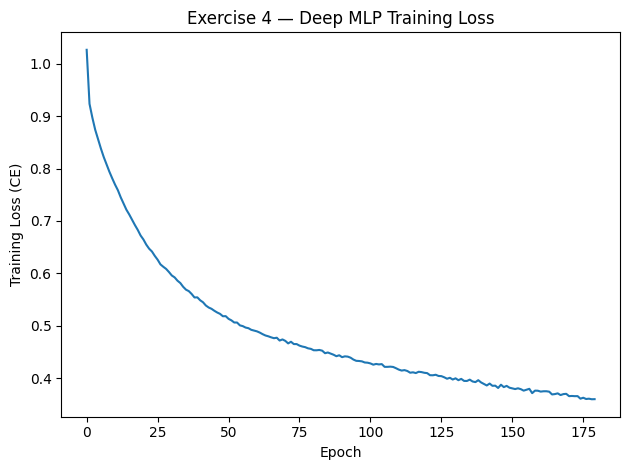

In [64]:
plt.figure()
plt.plot(np.arange(len(history)), history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (CE)")
plt.title("Exercise 4 — Deep MLP Training Loss")
plt.tight_layout()
plt.show()

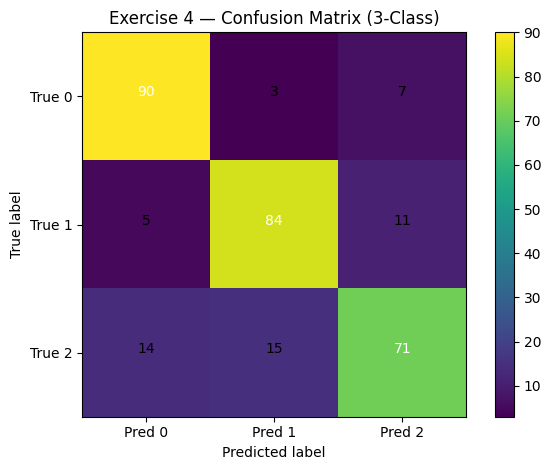

In [65]:
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Exercise 4 — Confusion Matrix (3-Class)")
plt.colorbar()
ticks=np.arange(3)
plt.xticks(ticks, [f"Pred {i}" for i in range(3)])
plt.yticks(ticks, [f"True {i}" for i in range(3)])
th=cm.max()/2.0
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], 'd'), ha="center", color="white" if cm[i, j] > th else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

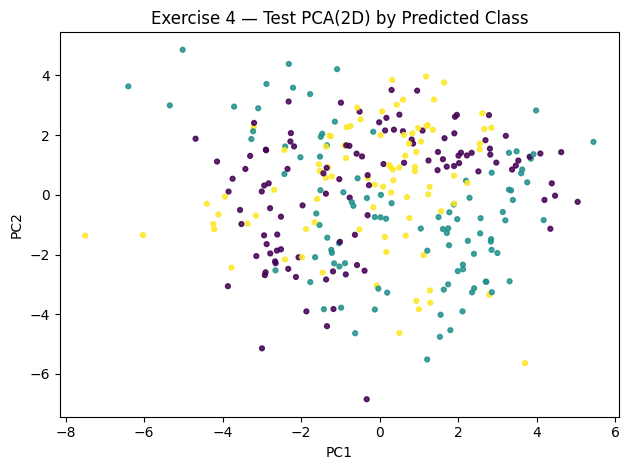

In [66]:

pca=PCA(n_components=2, random_state=0)
X2d=pca.fit_transform(X_test)
plt.figure()
plt.scatter(X2d[:,0], X2d[:,1], c=y_pred, s=12, alpha=0.85)
plt.title("Exercise 4 — Test PCA(2D) by Predicted Class")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()